# Vanilla Markowitz Model

Import the libraries

In [1]:
import numpy as np
import pandas as pd 

# For portfolio optimization
from scipy.optimize import minimize, LinearConstraint, Bounds
from matplotlib import pyplot as plt
import seaborn as sns

Reading Finance Data

In [2]:
# import the data from  local file
stock_data=pd.read_excel('Daily_Returns.xlsx')

# Convert the 'date' column to datetime format 
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set the 'date' column as the index
stock_data.set_index('Date', inplace=True)

Breaking training and testing

In [3]:
# Creating the training dataset 
train = stock_data['2000':'2016']

# Creating the testing dataset 
test = stock_data['2017':'2019']

# Creating the out of sample testing dataset 
out_of_sample = stock_data['2020':'2023']

Getting the initial data ready

In [4]:
#Renaming the training data
df = train

In [5]:
# Calculate return for each stock. 
r = np.mean(df,axis=0)

# Create a covariance matrix
covar = df.cov()

In [6]:
#rate of return for the whole portfolio
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))

#Find the total number of assets we are considering
num_assets = df.shape[1]

Creating the portfolio with the maximum return

In [15]:
# Function to minimize - negative portfolio returns (to maximize returns)
def negative_portfolio_returns(weights):
    return -np.sum(r * weights)


# Define a function to calculate portfolio volatility (risk)
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights, np.dot(weights, covar)))

In [16]:
#Sum of weights should be 1
weight_sum_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#Weights should be between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

#Initiate the weights
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=[weight_sum_constraint])

#Find the weights
w_max = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_max)
print("Return: %.2f%%" % (ret(r, w_max) * 100), "Risk:  %.2f%%" % (portfolio_volatility(w_max)*100))

Optimal Weights:
[0.00000000e+00 1.22102115e-01 2.95664334e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.19955435e-18 3.61658480e-18
 0.00000000e+00 4.12092013e-18 1.09524173e-18 1.37241183e-17
 0.00000000e+00 5.83130697e-17 0.00000000e+00 1.47771279e-17
 0.00000000e+00 0.00000000e+00 4.41116312e-17 5.88961562e-02
 9.12898221e-02 0.00000000e+00 9.48091857e-18 6.03937407e-18
 5.85408152e-17 3.46005514e-17 8.82321138e-19 0.00000000e+00
 2.63543913e-18 5.77881202e-18 0.00000000e+00 7.72387277e-19
 6.05471005e-18 1.77622162e-17 0.00000000e+00 1.33487740e-17
 9.78806121e-18 0.00000000e+00 7.03370678e-17 0.00000000e+00
 2.04809978e-01 2.80657894e-17 3.78686496e-02 3.96032875e-18
 1.19956284e-17 2.24973435e-17 1.99984172e-17 1.04985991e-18
 6.67299209e-18 1.41870299e-17 2.22008167e-17 3.23507184e-18
 2.45103561e-17 4.65300266e-18 4.97362888e-18 1.04274232e-17
 0.00000000e+00 2.64008131e-17 5.16288514e-18 8.71261064e-18
 0.00000000e+00 2.49592149e-17 0.00000000e+00 2.12697985e-17
 3.1486

Creating the portfolio with the minimum risk

In [18]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
constraint_matrix = np.ones((1, num_assets))
linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

# Find a portfolio with the minimum risk.
# Create x0, the first guess at the values of each stock's weight.
initial_weights = np.ones(num_assets) / num_assets

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(portfolio_volatility, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_min)
print("Return: %.2f%%" % (ret(r, w_min) * 100), "Risk:  %.2f%%" % (portfolio_volatility(w_min)*100))

Optimal Weights:
[2.11640389e-05 3.90506149e-03 1.95334313e-05 5.19748809e-05
 2.80680830e-05 5.32005917e-05 2.50152756e-05 1.04673666e-05
 7.05170415e-06 1.31295320e-05 2.27374042e-02 2.12386303e-05
 1.38901705e-05 1.23276959e-05 1.48287253e-05 3.49801895e-05
 3.63054476e-05 4.43441140e-05 6.71546462e-05 2.95424792e-05
 6.08084707e-05 6.51426998e-05 2.79756590e-05 2.03667651e-05
 2.90046542e-05 2.51831095e-05 3.32623050e-02 2.39871789e-05
 2.04035919e-05 1.03507417e-05 1.34618136e-02 2.52242081e-05
 8.41123208e-06 2.28187698e-03 2.13193111e-05 5.48072383e-02
 2.23771172e-03 2.86763643e-05 8.90681236e-03 9.04674991e-06
 4.07213329e-05 2.10318073e-05 2.03644035e-05 9.75488533e-05
 1.09710557e-01 2.20661578e-05 1.65473331e-05 2.18045511e-05
 7.05435947e-06 7.28558955e-02 4.81730549e-05 1.78761370e-05
 1.40724222e-05 7.39326154e-05 1.38064703e-05 2.87536941e-05
 5.21801783e-02 6.30425507e-05 1.83385863e-05 1.55679304e-05
 3.47972655e-04 1.76876384e-02 1.19688228e-05 1.88091798e-05
 9.6693

Finding the efficient frontier

In [19]:
#Let us now find the risk free rate
risk_free_values = [
    1.84 / 100,
    2.14 / 100,
    2.54 / 100,
    2.35 / 100,
    1.80 / 100,
    2.78 / 100,
    3.22 / 100,
    3.26 / 100,
    3.66 / 100,
    4.63 / 100,
    4.80 / 100,
    4.29 / 100,
    4.27 / 100,
    4.01 / 100,
    4.61 / 100,
    5.02 / 100,
    6.03 / 100
]

# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 


# Get the average risk free rate 
rfr = Average(risk_free_values)

#Get the daily risk free rate
rfr = rfr/365

In [20]:
# Define the new objective function to maximize return (minimize negative return)
def negative_portfolio_return(weights):
    return -ret(r, weights)  # We use the previously defined ret function

# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50
all_weights = np.zeros((num_ports, num_assets))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = portfolio_volatility(w_min)
vol_max = portfolio_volatility(w_max)
gap = (vol_max - vol_min) / (num_ports)

# Loop through to generate portfolios with increasing risk and maximizing return
for i in range(num_ports):
    target_vol = vol_min + i * gap

    # Constraint to ensure sum of weights is 1 and to fix the portfolio volatility
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                    {'type': 'ineq', 'fun': lambda weights: target_vol - portfolio_volatility(weights)}]  # Volatility not more than target
    bounds = Bounds(0, 1)

    #Find the optimum results
    result = minimize(negative_portfolio_return,initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Storing the results
    all_weights[i, :] = result.x
    ret_arr[i] = ret(r, result.x)
    vol_arr[i] = target_vol
 

# Calculate Sharpe ratios for each portfolio
sharpe_arr = (ret_arr-rfr)/ vol_arr


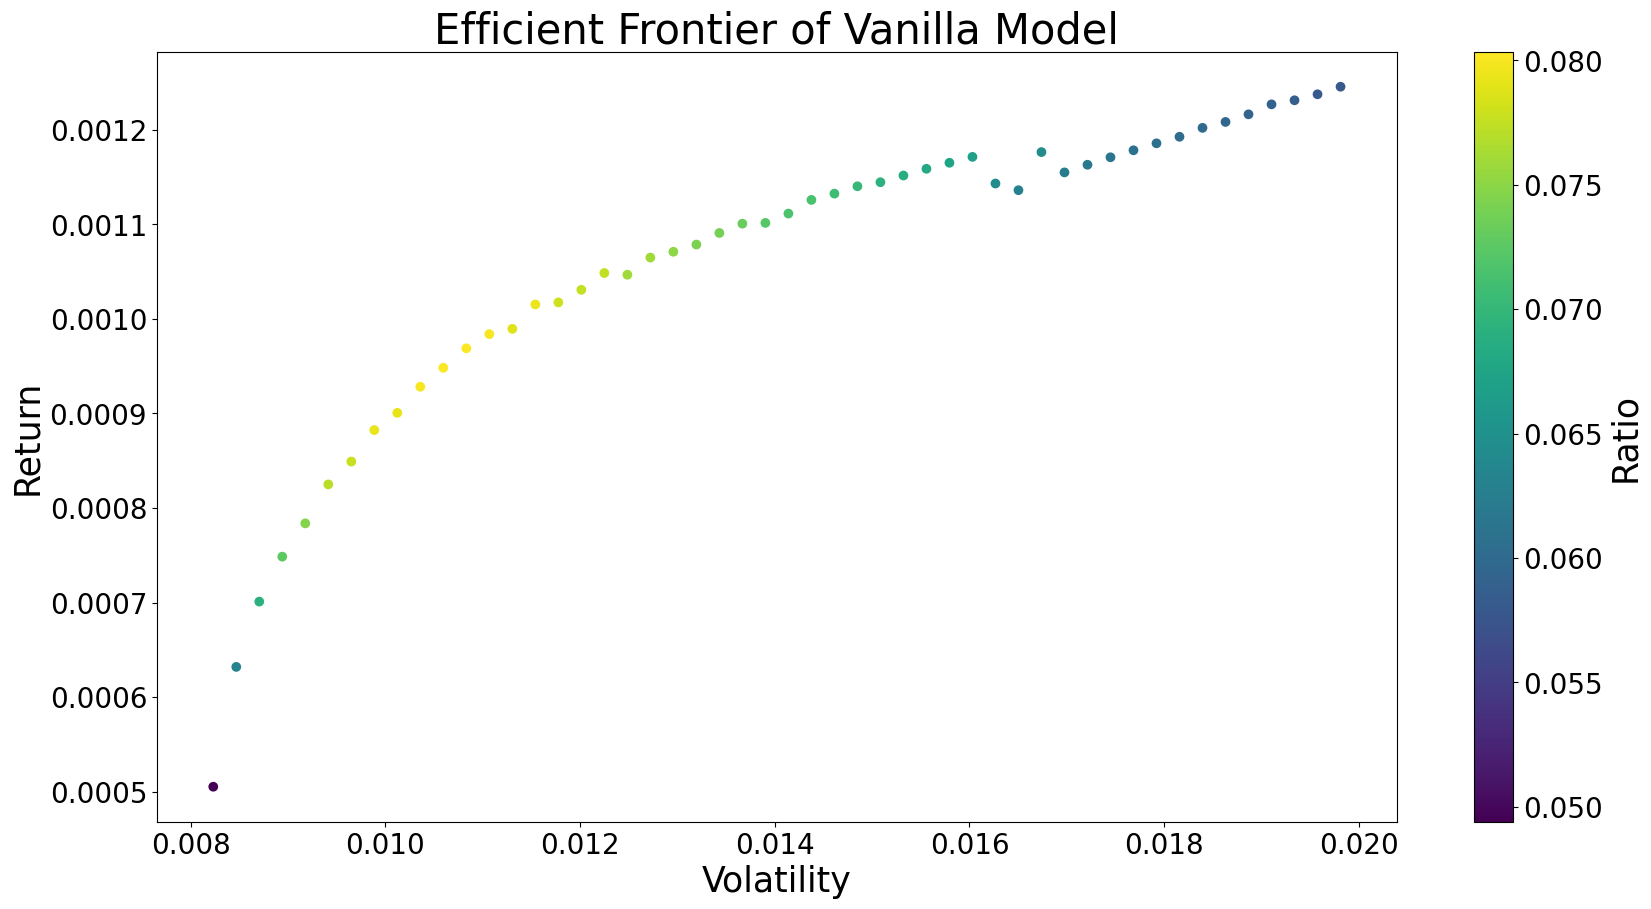

In [21]:

plt.figure(figsize=(20, 10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')

# Creating a colorbar and getting the colorbar object
cbar = plt.colorbar(label='Ratio')
cbar.set_label(label='Ratio', size=25)  # Set size for colorbar label
cbar.ax.tick_params(labelsize=20)       # Set size for colorbar ticks

# Set the fontsize for x and y labels
plt.xlabel('Volatility', fontsize=25)
plt.ylabel('Return', fontsize=25)

# Set the fontsize for x and y ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set the fontsize for the title
plt.title('Efficient Frontier of Vanilla Model', fontsize=30)

plt.show()

Finding the portfolio for a risk value of 1%

In [22]:
#Sum of weights must be 1 and the risk must be less than 1%
constraint = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'ineq', 'fun': lambda weights: 0.01 - portfolio_volatility(weights)}]
                         

#Weights are between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=constraint)

#Find the weights
w_allocation = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_allocation)
print("Return: %.2f%%" % (ret(r, w_allocation) * 100), "Risk:  %.2f%%" % (portfolio_volatility(w_allocation)*100))

Optimal Weights:
[1.22391793e-19 5.80146771e-02 0.00000000e+00 1.40593330e-18
 1.80849289e-18 0.00000000e+00 8.97801145e-19 8.18543003e-18
 3.53139402e-18 1.81123469e-18 4.67168718e-03 0.00000000e+00
 0.00000000e+00 4.84889242e-19 6.82729546e-19 1.15647163e-18
 4.23689191e-18 0.00000000e+00 3.43994223e-18 0.00000000e+00
 4.23617201e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.08996920e-18 0.00000000e+00 2.42709835e-02 3.64624810e-18
 2.71602282e-18 0.00000000e+00 7.41368747e-02 0.00000000e+00
 1.48823274e-18 0.00000000e+00 3.22924466e-20 3.41010231e-02
 2.30992378e-02 6.53000353e-05 4.13623329e-02 0.00000000e+00
 2.14251238e-03 0.00000000e+00 1.12856050e-02 0.00000000e+00
 1.67765103e-03 0.00000000e+00 0.00000000e+00 4.32853542e-20
 1.45401580e-18 2.17127007e-02 0.00000000e+00 1.01031618e-18
 2.93526668e-18 0.00000000e+00 2.38927170e-18 1.14628898e-18
 7.17397312e-02 0.00000000e+00 1.20694030e-18 0.00000000e+00
 0.00000000e+00 7.20468664e-04 1.63845366e-18 0.00000000e+00
 0.0000

Creating the asset allocation chart

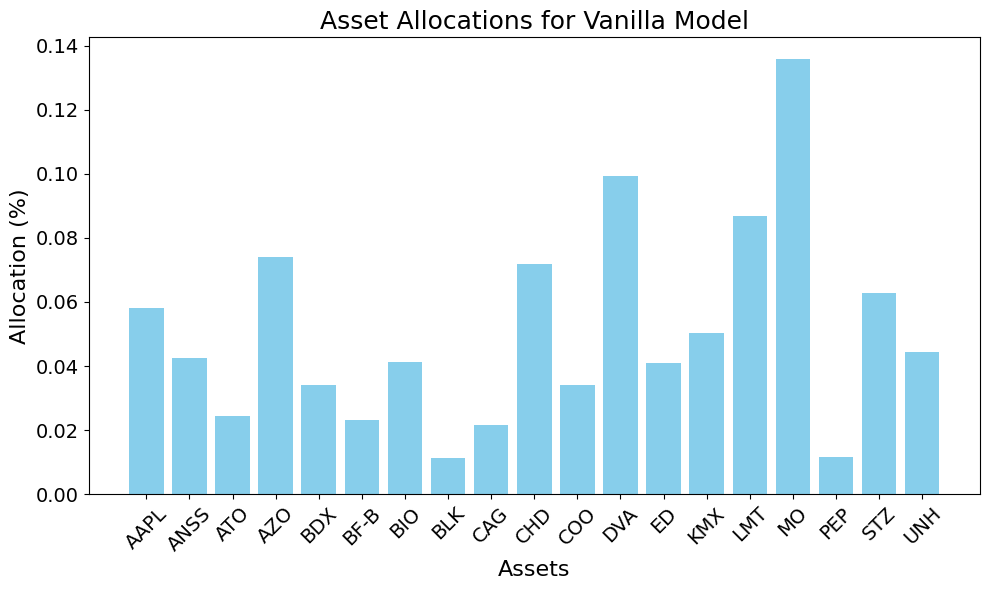

In [23]:
column_names = df.columns.tolist()

# Filter the weights and corresponding names for weights > 0.01
filtered_weights = [w for w in w_allocation if w > 0.01]
filtered_names = [column_names[i] for i, w in enumerate(w_allocation) if w > 0.01]

# Optionally set default font sizes using rcParams
plt.rcParams['axes.labelsize'] = 16  # Default font size for x and y labels
plt.rcParams['xtick.labelsize'] = 14 # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14 # Font size for y-axis tick labels
plt.rcParams['axes.titlesize'] = 18  # Font size for title


# Plotting the bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(filtered_names, filtered_weights, color='skyblue') 
plt.xlabel('Assets')  # Adding x-label
plt.ylabel('Allocation (%)')  # Adding y-label
plt.title('Asset Allocations for Vanilla Model')  # Adding title
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability if names are long
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Creating the correlation heatmap

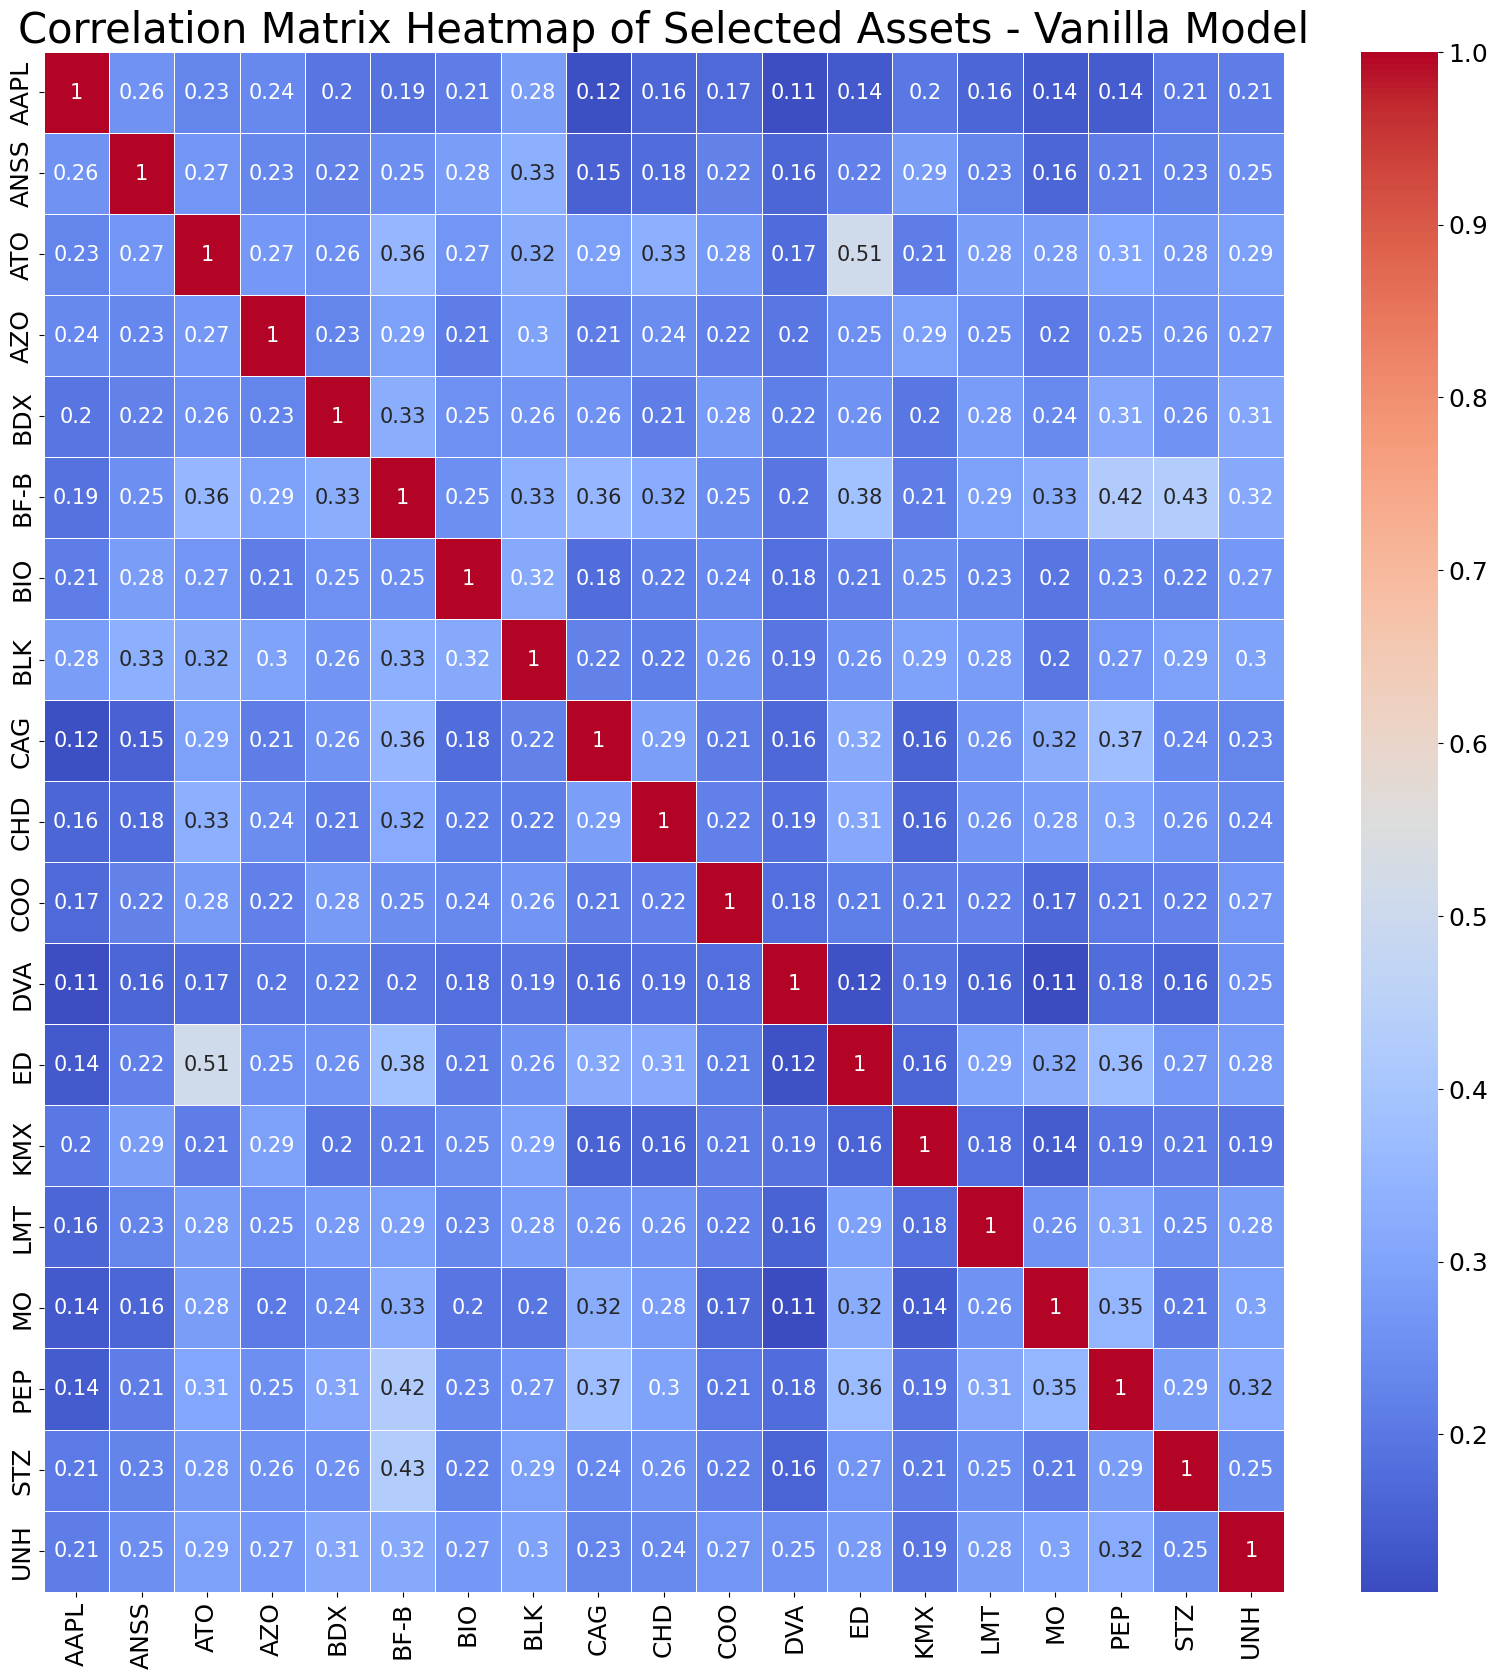

In [25]:
# Filter columns in df where the corresponding weight in w_min is greater than 0
filtered_df = df[filtered_names]

# Compute the correlation matrix
corr_matrix = filtered_df.corr()

# Optionally set default font sizes using rcParams for global settings
plt.rcParams['axes.labelsize'] = 20  # Default font size for x and y labels
plt.rcParams['xtick.labelsize'] = 18 # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 18 # Font size for y-axis tick labels
plt.rcParams['axes.titlesize'] = 22  # Font size for title

plt.figure(figsize=(20, 20))
# Use annot_kws to specify the font size of the annotations inside the heatmap
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 15}, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap of Selected Assets - Vanilla Model',fontsize=30)
plt.show()


Now let us create a dataframe of results

In [26]:
#Get the values
returns = ret(r, w_allocation) * 100
risk = portfolio_volatility(w_allocation)*100

# Append the values to the DataFrame
new_row = pd.DataFrame({'return': [returns], 'risk': [risk]})

#Save the dataframe
new_row.to_excel("Vanilla_Results.xlsx",index=False)

Testing the model

In [27]:
# Calculate expected returns for each asset
expected_returns_test = np.mean(out_of_sample,axis=0)

#Converting the expected returns to a numpy array
expected_returns_test = expected_returns_test.values

In [28]:
#Actual Return
Actual_Return_out_of_Sample = ret(expected_returns_test, w_allocation) 
print(Actual_Return_out_of_Sample )

0.000494223499055595


In [29]:
# Calculate expected returns for each asset
expected_returns_test = np.mean(test,axis=0)

#Converting the expected returns to a numpy array
expected_returns_test = expected_returns_test.values

In [30]:
#Actual Return
Actual_Return = ret(expected_returns_test, w_allocation) 
print(Actual_Return)

0.0006353431751100367
